In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from processwx import select_stn, process_stn
%matplotlib inline
%config InlineBackend.figure_format='retina'

# EDA with Teton avalanche observations and hazard forecasts



I've already preprocessed the avalanche events and forecasts, so we'll just load them into dataframes here:

In [2]:
events_df = pd.read_csv('btac_events.csv.gz', compression='gzip', 
                        index_col=[0], parse_dates = [2])
hzrd_df = pd.read_csv('btac_nowcast_teton.csv.gz', compression='gzip', 
                      index_col=[0], parse_dates=[0])

Since we dont't have hazard forecasts for non-Jackson regions, let's filter events in those areas out. I infer the 
list of zones from the [BTAC obs page](http://jhavalanche.org/observations/viewObs).

In [3]:
zones = ['101','102','103','104','105','106','JHMR','GT','SK']
df1 = events_df[events_df['zone'].isin(zones)]

Let's take a look at the event data. The first 10 columns contain data on the time, location, and characteristics of the slide path:

In [4]:
df1[df1.columns[0:10]].head(10)

,ID,event_date,event_time,zone,pathname,elevation,lat,lng,aspect,slope_angle
1,2094.0,2000-12-01,None,104,Glory Bowl,9800.0,43.505112,-110.948463,E,41-45
2,2095.0,2000-12-09,None,104,Titmouse Ridge,8000.0,43.489483,-110.950050,E,41-45
3,2096.0,2000-12-25,None,106,South Badger Creek,9200.0,43.893562,-110.908119,S,31-35
4,2097.0,2001-02-06,None,105,Ralphs Slide,9800.0,43.592175,-110.878319,S,41-45
5,2098.0,2001-02-23,None,105,Caldonia Couloir Area,8000.0,43.610756,-110.831970,N,41-45
10,2104.0,2003-01-04,None,105,Near Ski Lake,9200.0,43.526413,-110.936897,NE,36-40
13,2107.0,2003-01-27,None,104,Avalanche Bowl,8600.0,43.484516,-110.951447,E,41-45
14,2108.0,2003-02-10,None,JHMR,Hourglass Couloir,10150.0,43.598717,-110.870293,NE,41-45
16,2110.0,2004-01-31,None,105,Pyramid Peak,8900.0,43.547104,-110.886559,S,36-40
18,2112.0,2006-01-05,None,104,East Face of Taylor,9800.0,43.528904,-110.978439,E,41-45


These fields are largely self explanatory; elevation is reported in feet above mean sea level.

After that, we get details on the size, type, and trigger for the avalanche, as well as the number of people killed:

In [5]:
df1[df1.columns[10:16]].head(10)

,destructive_size,relative_size,depth,avy_trigger,fldType,fatality
1,2.5,3.0,24.0,AR,SS,1.0
2,1.0,1.0,12.0,AS,SS,1.0
3,3.0,3.0,24.0,AS,SS,1.0
4,2.0,3.0,18.0,AS,SS,1.0
5,1.5,1.0,18.0,AS,SS,1.0
10,2.5,2.0,48.0,AR,HS,1.0
13,2.0,2.0,24.0,AR,SS,1.0
14,3.0,3.0,24.0,AS,SS,1.0
16,4.0,4.0,48.0,AS,SS,1.0
18,3.0,3.0,72.0,AS,SS,1.0


A guide to avalanche terminology and codes is available [here](http://www.americanavalancheassociation.org/pdf/Avalanche_data_codes.pdf). Destructive size and relative size describe the magnitude of the slide, depth is the initial thickness in inches of the snow slab that slides. The trigger describes the source of the disturbance causing the slide, while type describes the nature of the slab.

Finally, we get notes and info on the reporting individual, if available:

In [6]:
df1[df1.columns[16:]].head(10)

,observer,affiliation,notes
1,None,None,None
2,None,None,Lone skier buried by a small slide in a terrai...
3,None,None,The skier was the third person to cross this s...
4,None,None,Skier swept over cliff.
5,None,None,Buried skier was quickly uncovered by companio...
10,None,None,Snow boarder caught and carried. Died from tr...
13,None,None,The snowboarder was alone and had been missing...
14,None,None,Lift skier caught and buried in a closed area ...
16,None,None,Solo skier caught and buried by a large avalan...
18,None,None,Skier caught and buried by a large avalanche.


Let's look at a quick count of the events in our database by year:

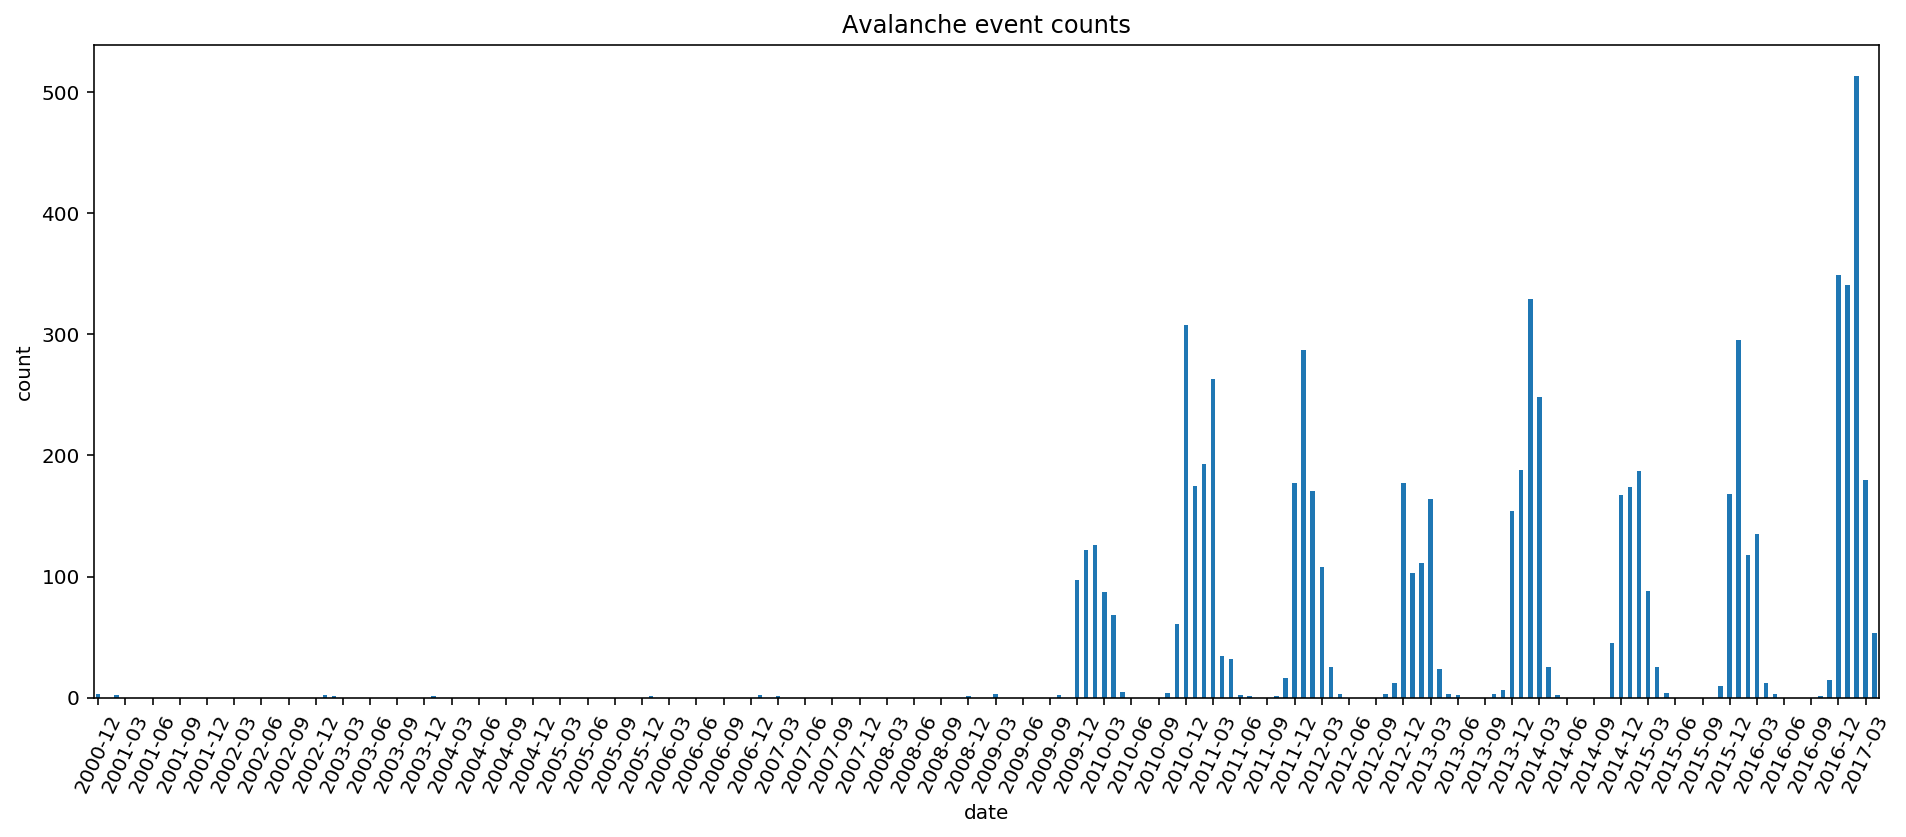

In [7]:
per = df1['event_date'].dt.to_period("M");
g = df1.groupby(per);
s1 = g['ID'].count();
fig, ax = plt.subplots(1,1,figsize=(16,6));
s1 = s1.resample('M').sum();
s1.plot(kind='bar', ax=ax, title='Avalanche event counts', rot=65);
ticks = ax.xaxis.get_ticklocs();
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()];
ax.xaxis.set_ticks(ticks[::3]);
ax.xaxis.set_ticklabels(ticklabels[::3]);
ax.set_xlabel('date');
ax.set_ylabel('count');

What's going on here? It turns out initially, the only events in our data are serious accidents. In the winter of 2009-2010, the ski patrol at Jackson Hole began reporting the results of their avalanche control work, and a broader range of non-accident reports from skiers and snowmobilers are included. The raw observation counts are thus tricky to compare from year to year.

Total fatalities: 25.0


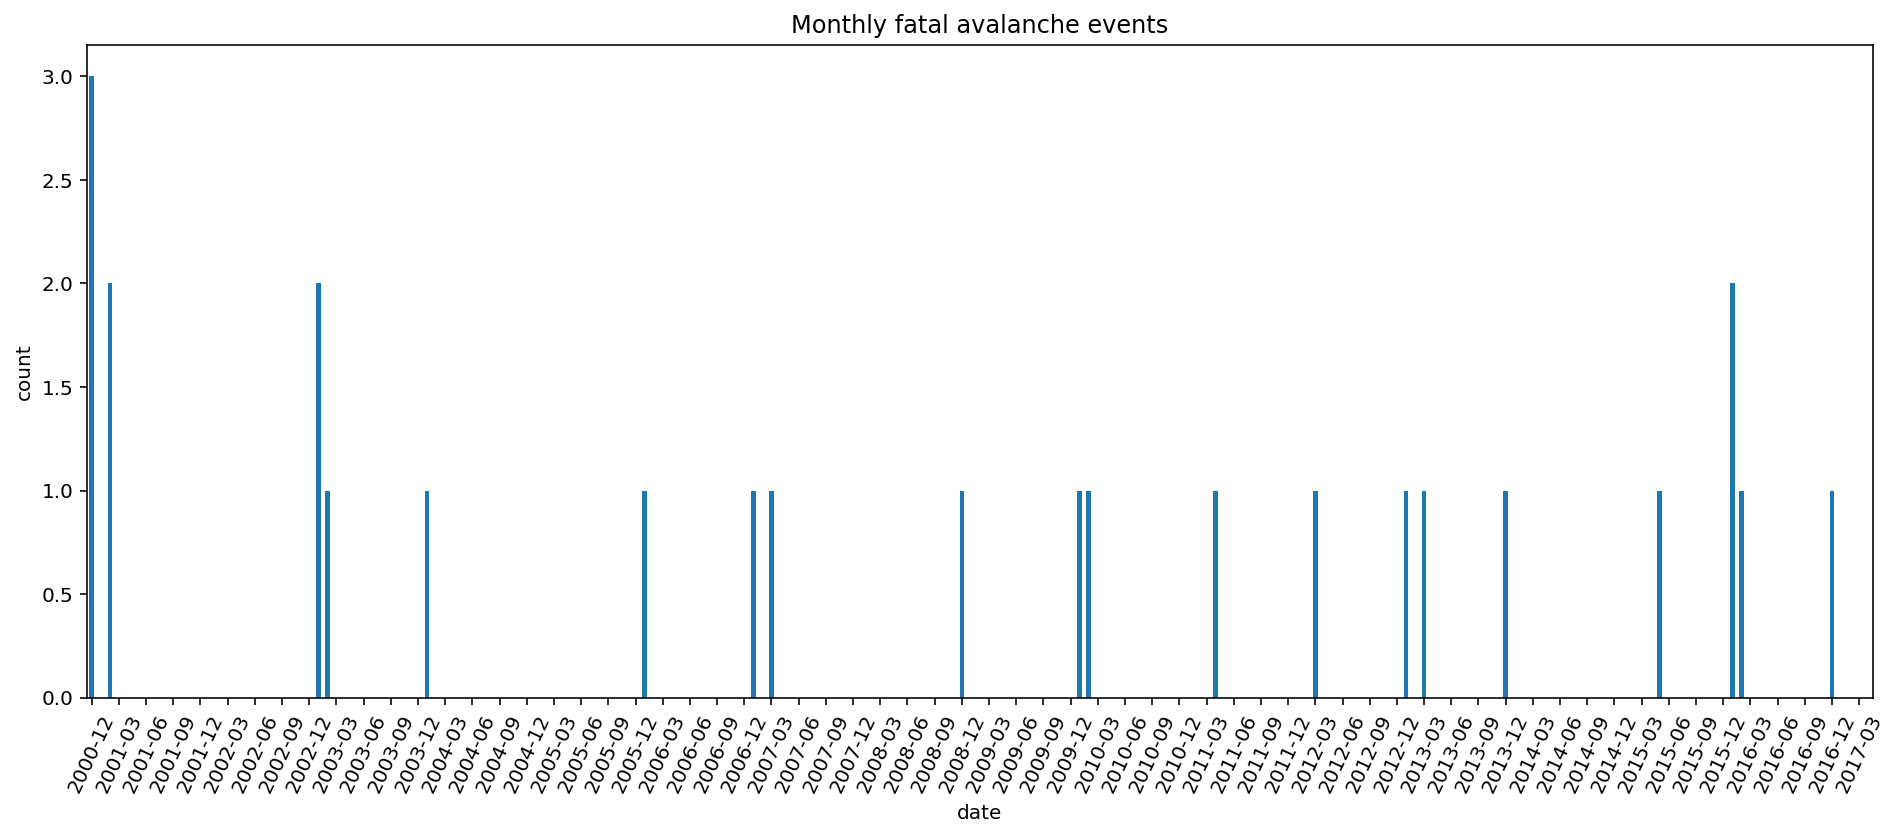

In [8]:
per = df1['event_date'].dt.to_period("M");
g = df1.groupby(per);
s2 = g['fatality'].sum().astype(int);
fig, ax = plt.subplots(1,1,figsize=(16,6));
s2 = s2.resample('M').sum();
s2.plot(kind='bar', ax=ax, title='Monthly fatal avalanche events', rot=65);
ticks = ax.xaxis.get_ticklocs();
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()];
ax.xaxis.set_ticks(ticks[::3]);
ax.xaxis.set_ticklabels(ticklabels[::3]);
ax.set_xlabel('date');
ax.set_ylabel('count');
print("Total fatalities:",s2.sum())

So in our 16 year record, we have 25 avalanche fatalities in the jackson hole region. With such a small sample, hard to see any particular pattern. 

Let's start examining these events in the context of the avalanche forecasts. First, the data (last 5 days shown):

In [9]:
hzrd_df.tail(10)

,region,atl,tl,btl
date,,,,
2017-04-08 09:00:00,teton,2,1,1
2017-04-08 15:00:00,teton,2,2,1
2017-04-09 09:00:00,teton,2,1,1
2017-04-09 15:00:00,teton,2,1,1
2017-04-10 09:00:00,teton,2,1,1
2017-04-10 15:00:00,teton,2,1,1
2017-04-11 09:00:00,teton,2,1,1
2017-04-11 15:00:00,teton,2,1,1
2017-04-12 09:00:00,teton,2,1,1


Each column is for a specific terrain elevation (atl is "above treeline", tl is "treeline", btl is "below treeline"), representing the forecast hazard level from 1-5 (low to extreme). The equivalent elevation bands are 6000-7500ft, 7500-9000ft, and 9000-10500ft. The daily bulletin gives an expected hazard for the morning and afternoon - in late winter and spring, the longer days and warming temperatures can create significant intrady increases in hazard. This is what the hazard looked like over the course of the 2008-2009 season:

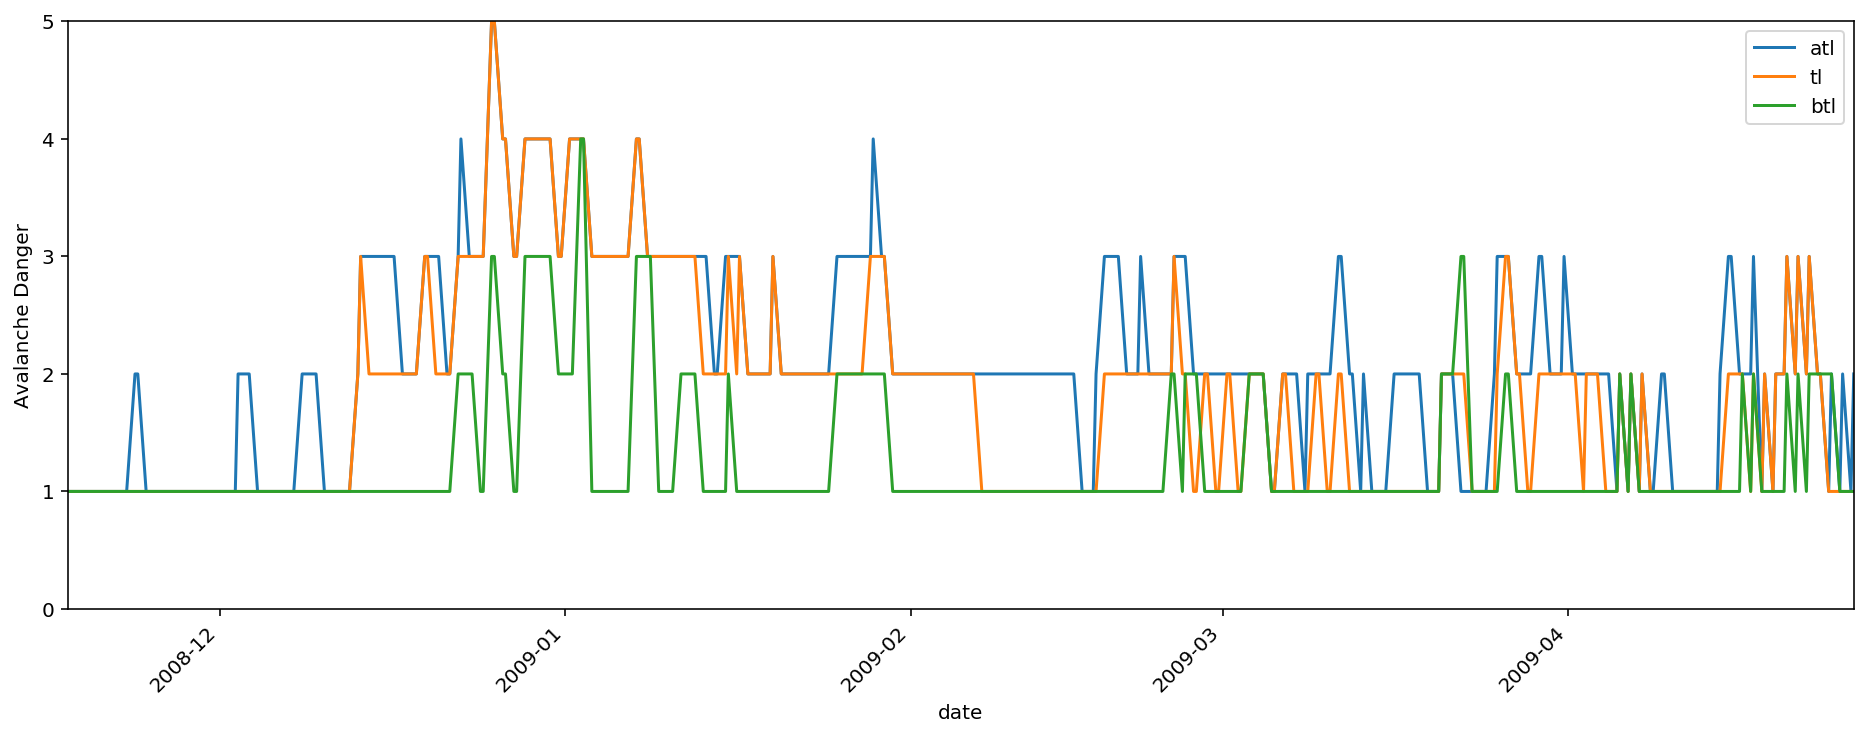

In [10]:
s = ('2008-10-31','2009-5-31')
#s = ('2013-10-31','2014-5-31')
#s =('2016-10-31','2017-5-31')

ax = hzrd_df.loc[s[0]:s[1],['atl','tl','btl']].plot(figsize=(16,6),rot=45);
ax.set_ylim([0,5]);
ax.set_ylabel('Avalanche Danger');

Peak hazard occurred in late December to early January. The increased intraday variation in hazard is visible from March forward, with higher hazard in the afternoons.

What forecast conditions have the highest number of fatalities? We don't have a very impressive sample with just one region of a single state, but we can at least see how to approach it. We want to extract the appropriate forecast hazard for the date and elevation where fatalities occurred.

First, we make a function to categorize elevations:

In [11]:
def elevation_category(elevation):
    if (6000. < elevation <= 7500.):
        return 'btl'
    elif (7500. < elevation <= 9000.):
        return 'tl'
    elif (9000. < elevation <= 10500.):
        return 'atl'
    else:
        return None

Next we augment the event frame with the elevation category in which the slide occurred:

In [12]:
df1.is_copy=False
df1['el_cat'] = df1['elevation'].apply(lambda x: elevation_category(x))

We next average the morning and afternoon hazard levels, then stack and reindex the hazard frame in preparation for a left outer join with the event frame:

In [13]:
df2 = hzrd_df[['atl','tl','btl']].resample('D').mean().stack()
df2 = df2.reset_index()
df2.columns = ['event_date','el_cat','hazard']
df2.head()

,event_date,el_cat,hazard
0,1999-11-29,atl,1.0
1,1999-11-29,tl,1.0
2,1999-11-29,btl,1.0
3,1999-11-30,atl,1.0
4,1999-11-30,tl,1.0


Finally, we merge these frames, then restrict the analysis to fatal accidents. While the sample size is small, we recover the frequently noted result that more fatal accidents occur during "Considerable" forecast hazard than "High" or "Extreme". This is both the result of the underlying hazard frequency (there are more "Considerable" days than "High" or "Extreme" days) and psychology (fewer people choose to recreate in avalanche terrain when the forecast danger is above "Considerable").

In [14]:
df3  = pd.merge(df1, df2, how='left', left_on=['event_date','el_cat'], right_on=['event_date','el_cat'])


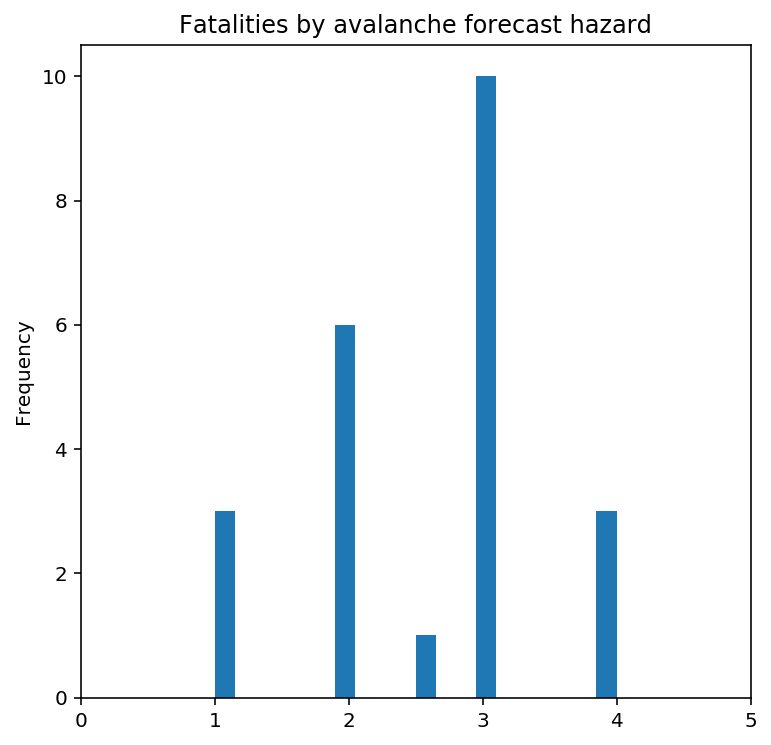

In [15]:
df4 = df3[df3['fatality']>0]
df4['hazard'].plot(kind='hist', title='Fatalities by avalanche forecast hazard', 
                   xlim=[0,5], bins=20, figsize=(6,6));

The stacked histogram of forecast avalanche danger by elevation category has a lognormal character.

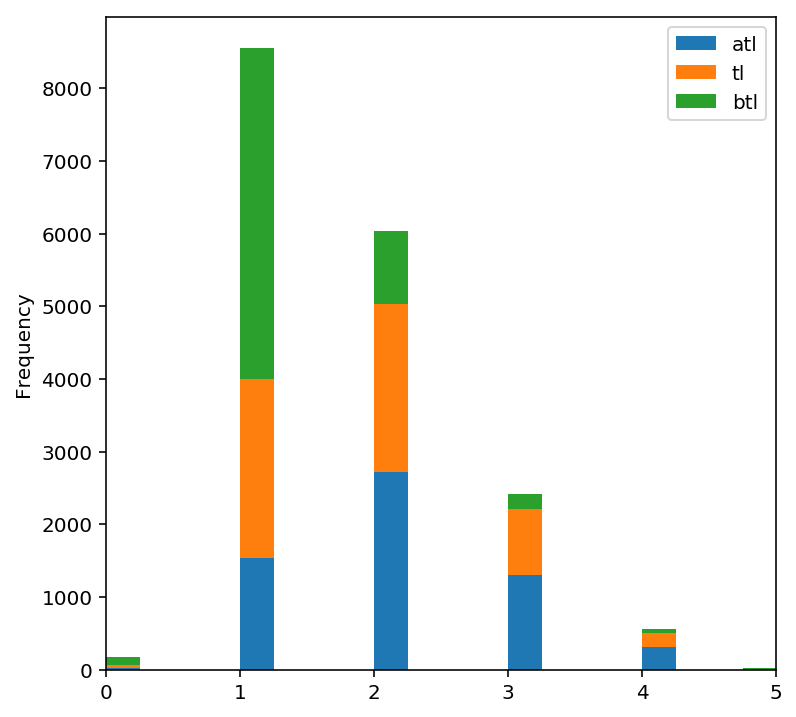

In [16]:
hzrd_df[['atl','tl','btl']].plot(kind='hist', stacked=True, 
                                 xlim=[0,5], bins=20, figsize=(6,6));

The raw count of avalanches by hazard rating is given below:

In [17]:
g = df3.groupby(by='hazard');
g['ID'].count()

hazard
0.0       8
1.0     202
1.5     104
2.0    1702
2.5     272
3.0    2378
3.5     184
4.0    1528
4.5       5
5.0      55
Name: ID, dtype: int64

and here, raw counts of forecasts per hazard rating

In [18]:
atl1, b = np.histogram(hzrd_df['atl'], bins=20);
tl1, _ = np.histogram(hzrd_df['tl'], bins=20);
btl1, _ = np.histogram(hzrd_df['btl'], bins=20);
atl1+tl1+btl1

array([ 172,    0,    0,    0, 8551,    0,    0,    0, 6034,    0,    0,
          0, 2411,    0,    0,    0,  555,    0,    0,   19])

In [19]:
b

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ])

While this is "quick and dirty", the forecast frequence weighted avalanche occurrence suggests there are about three events per fcst at "high" and "extreme" hazard, about one per forecast at "considerable", less than 1/3 per forecast at "moderate", and 1/40 per forecast at "low".

# Weather

Having examined avalanche forecasts and observations, the next challenge is to address the driving variable: weather. We'll take a quick look at some station data from Jackson Hole.

First, let's look at the data sources available. I've coded a handy utility to help pick out useful stations. Let's find the ten nearest Jackson Hole, with (lat, lon) = (43.572236,-110.8496103):

In [22]:
df = select_stn('./wxdata',{'k_nrst': 10, 'lat_lon': (43.572236,-110.8496103)}, return_df=True)

In [23]:
df.head(10)

,stid,mnet_id,name,latitude,longitude,elevation,state,rec_start,rec_end,dist
0,JHB,48,JACKSON HOLE-BASE,43.580000,-110.850000,6339,WY,1999-11-23 00:00:00,2017-04-11 23:15:00,0.864159
1,JHBUF,48,JACKSON HOLE-BUFFALO BOWL,43.590147,-110.848994,7913,WY,2016-01-04 20:40:00,2017-04-11 23:15:00,1.992856
2,JHMWY,48,JACKSON HOLE-MID MT,43.590000,-110.840000,8179,WY,2016-01-04 21:55:00,2017-04-11 23:15:00,2.122202
3,JHRV,48,JACKSON HOLE-RENDEZVOUS BOWL,43.590858,-110.872558,9608,WY,2010-02-06 00:00:00,2017-04-11 23:15:00,2.776535
4,JHR,48,JACKSON HOLE-RAYMER,43.600000,-110.850000,9360,WY,1998-12-08 00:00:00,2017-04-11 23:15:00,3.088345
5,JHS,48,JACKSON HOLE-SUMMIT,43.596969,-110.870756,10318,WY,2016-01-04 20:40:00,2017-04-11 23:15:00,3.235876
6,PHBW4,25,PHILLIPS BENCH,43.519480,-110.911030,8200,WY,2000-01-20 00:00:00,2017-04-11 23:00:00,7.678150
7,SNKWY,48,SNOW KING,43.463100,-110.763000,7810,WY,2007-11-11 00:00:00,2017-04-11 23:15:00,14.005828
8,GTHW4,25,GRAND TARGHEE,43.779330,-110.927830,9260,WY,2006-10-23 00:00:00,2017-04-11 23:00:00,23.879060
9,GTFM,48,Freds Mountain Summit,43.786630,-110.934230,9840,WY,2011-01-13 00:00:00,2017-04-11 23:15:00,24.799513
